In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from sksurv.metrics import concordance_index_censored
from lifelines.datasets import load_rossi

data = load_rossi()
data.dropna(inplace=True)
print(data.shape)
data.head()

(432, 9)


,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [2]:
event_col = "arrest"
duration_col = "week"

X = data.drop(columns=[event_col, duration_col])
X.shape

(432, 7)

# Train-test split

In [3]:
from utils.data import train_test_splitting

train_idx, test_idx = train_test_splitting(
    np.arange(data.shape[0]), test_size=0.2, stratify=data[event_col].squeeze().astype(int)
)
# Data splits
data_train, data_test = data.iloc[train_idx], data.iloc[test_idx]
print(data_train.shape, data_test.shape)

(345, 9) (87, 9)


In [4]:
duration_train = data_train[duration_col].to_numpy().squeeze()
duration_test = data_test[duration_col].to_numpy().squeeze()

event_train = data_train[event_col].to_numpy().squeeze()
event_test = data_test[event_col].to_numpy().squeeze()

In [5]:
from sksurv.util import Surv
# Create structured arrays
y_train = Surv.from_arrays(event=event_train, time=duration_train)

# Pre-processing 

In [6]:
from utils.data import feature_scaling
# Scale features with Z-score transfrom 
X_train, X_test = feature_scaling(X.iloc[train_idx].values, X.iloc[test_idx].values)

In [7]:
from utils.data import init_knots
# Set knot locations 
knots = init_knots(duration_train, event_train, n_knots=5)
min(knots), max(knots)

(0.0, 3.9512437185814275)

# Initialize clients

In [8]:
N_SPLITS = 2
DATA_SPLIT_IDX = np.array_split(np.arange(data_train.shape[0]), N_SPLITS)

In [9]:
from utils.client import Client 

participants = [] 

for idx in DATA_SPLIT_IDX:
    # Init client objects with mutually exclusive data samples 
    client = Client(data_train.iloc[idx], n_knots=5, n_epochs=1, event_col=event_col, duration_col=duration_col)
    
    # Apply data pre-processing steps 
    client.preprocess_data(train_test_split=False)
    
    # Initialize model and parameters 
    client.init_model(local_knots=False, knots=knots)
    #print(client.X_train.mean())
    #assert asf 
    participants.append(client)

2025-05-04 12:40:52.762447: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Initialize parameters

In [10]:
from utils.data import init_gamma, init_beta
from utils.splines import bspline_design_matrix

# Create one spline equation per time point 
D = bspline_design_matrix(np.log(duration_train), knots)

# Initialize gamma coefficients
z_gamma = init_gamma(D, duration_train)

# Initialize beta coefficients
z_beta = init_beta(X_train, y_train)

In [11]:
for client in participants:
    client.set_params({"beta": z_beta, "gamma": z_gamma})

# Client fitting

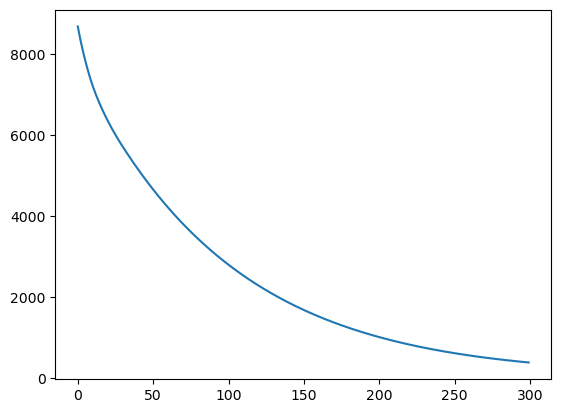

In [12]:
def server_update(beta_locals, gamma_locals):
    return np.mean(beta_locals, axis=0), np.mean(gamma_locals, axis=0)
    

losses = []
for _ in range(300):

    beta_locals, gamma_locals, last_local_losses = [], [], [] 
    for client in participants:

        client.fit_model(z_beta, z_gamma)

        # Local update 
        beta_locals.append(client.beta)
        gamma_locals.append(client.gamma)

        # Trace training loss 
        last_local_losses.append(client.loss)
    
    losses.append(np.mean(last_local_losses))
    
    # Global update
    z_beta, z_gamma = server_update(beta_locals, gamma_locals)

plt.figure()
plt.plot(losses)

# Global model

In [13]:
from utils.model import Model 

global_beta, global_gamma = server_update(beta_locals, gamma_locals)

global_model = Model(epochs=0, knots=knots, learning_rate=0.01, l2_lambda=0)
global_model.set_params({"beta": global_beta, "gamma": global_gamma})

In [14]:
print(concordance_index_censored(event_train.astype(bool), duration_train, global_model.risk_score(X_train).squeeze()))
print(concordance_index_censored(event_test.astype(bool), duration_test, global_model.risk_score(X_test).squeeze()))

(0.6501603331981866, 17624, 9476, 31, 1016)
(0.6038885664538596, 1040, 682, 1, 0)


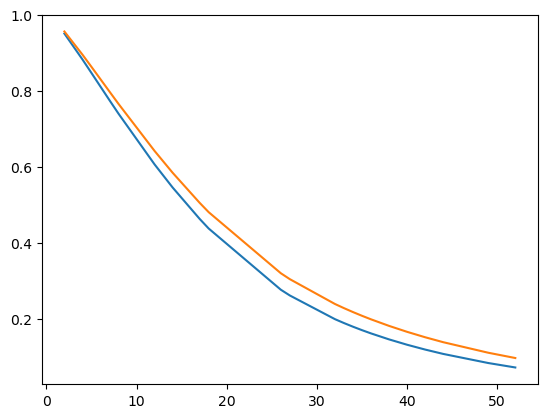

In [15]:
S0 = global_model.survival_curve(X_test[0], duration_test)
S1 = global_model.survival_curve(X_test[1], duration_test)

plt.figure()
idx = np.argsort(duration_test)
plt.plot(duration_test[idx], S0[idx, 0])
plt.plot(duration_test[idx], S1[idx, 0])

In [16]:
global_model.gamma

array([[-2.9999676 , -2.0365162 , -0.9257936 ,  0.32793236,  0.6815543 ,
         0.8878994 ,  0.9512468 ]], dtype=float32)

In [17]:
global_model.beta

array([[-0.0311098 , -0.03913317,  0.03522462, -0.03946244, -0.02620818,
         0.00536317,  0.08266788]], dtype=float32)